# Modelling xwOBA (With KNN)

### By: Thomas Nestio [(@TJStats)](https://twitter.com/TJStats)
##### [GitHub](https://github.com/tnestico), [LinkedIn](https://www.linkedin.com/in/thomas-nestico-b66013173/), [Medium](https://medium.com/@thomasjamesnestico)


### Introduction
Analytics in baseball has developed throughout the years to better capture a player’s value at all facets of the game. One of the most noteworthy developments was the creation of the all encompassing offensive metric “Weighted On-Base Average”, also known as wOBA. This article will dive deeper into wOBA and its applications. Additionally, I will go through my process of creating an “expected” wOBA metric (xwOBA), similar to the one that is defined by MLB and accessible via Baseball Savant.

This Notebook includes all code that I wrote for the projec.

#### Import Packages

In [1]:
## Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.gridspec import GridSpec

## Define colourblind acessible colour palette
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2',
                  '#894D80','#16AA02','#B5592B',
                  '#A3C1ED']

#### Import Data
The data used for this project was gathered form the MLB Stats API. Data is from the 2020 through 2023 seasons. This data includes all relevant batted ball metrics and outcomes. 2020 to 2022 data will be used for training and testing. 2023 data will be used to compare predicted xwOBA to MLB xwOBA (from Baseball Savant)

In [5]:
## Download data for training and testing
import datasets
from datasets import load_dataset

## Download data from 2020 to 2023 seasons                                                       
dataset = load_dataset('nesticot/mlb_data', data_files=['mlb_pitch_data_2023.csv',
                                                        'mlb_pitch_data_2022.csv',
                                                        'mlb_pitch_data_2021.csv',
                                                        'mlb_pitch_data_2020.csv'])
dataset_train = dataset['train']

## Convert dataset into Pandas Dataframe
df = dataset_train.to_pandas().set_index(list(dataset_train.features.keys())[0]).reset_index(drop=True)

#### Transform Data


In [6]:
# Add a season column to separate 2020 to 2022 data from 2023 data
df['season'] = df['game_date'].str[0:4].astype(int)

## Classify if an event is a Batted Ball Event 
df['bip'] = [1 if x > 0  else np.nan for x in df['launch_speed']]

## Define a 'Total Bases' column to define batted ball outcomes
conditions_tb = [(df['event_type']=='single'),
                 (df['event_type']=='double'),
                 (df['event_type']=='triple'),
                 (df['event_type']=='home_run')]

## Assign 'Total Bases' value to each condition
choices_tb = [1,
              2,
              3,
              4]

## Assign Total Base Value to batted ball events. 0 for all field outs
df['tb'] = np.select(conditions_tb, choices_tb, default=0)

## Define a 'wOBA' column to calculate wOBA for each event 
## We will use this later to compare to our xwOBA metric
conditions_woba = [(df['event_type']=='walk'),
                   (df['event_type']=='hit_by_pitch'),
                   (df['event_type']=='single'),
                   (df['event_type']=='double'),
                   (df['event_type']=='triple'),
                   (df['event_type']=='home_run')]

choices_woba =    [0.696,
                   0.726,
                   0.883,
                   1.244,
                   1.569,
                   2.004]

df['woba'] = np.select(conditions_woba, choices_woba, default=0)

## Filter out all non-batted ball events for training
df_bip = df[~df['bip'].isnull()].dropna(subset=['launch_speed','launch_angle','bip'])

## Train on 2020-22 Data and keep 2023 Data for analysis
df_bip_train = df_bip[~(df_bip['season'] == 2023)]
df_bip_2023 = df_bip[df_bip['season'] == 2023]
                 
## Filter out 2023 data for use later
df_2023 = df[df['season'] == 2023]

MLB calculates xwOBA using Launch Angle and Launch Speeds. We will be doing the same for our model.

To better visualize the data and the interaction between Launch Speed and Launch Angle with respect to Total bases, we can plot a KDE plot.

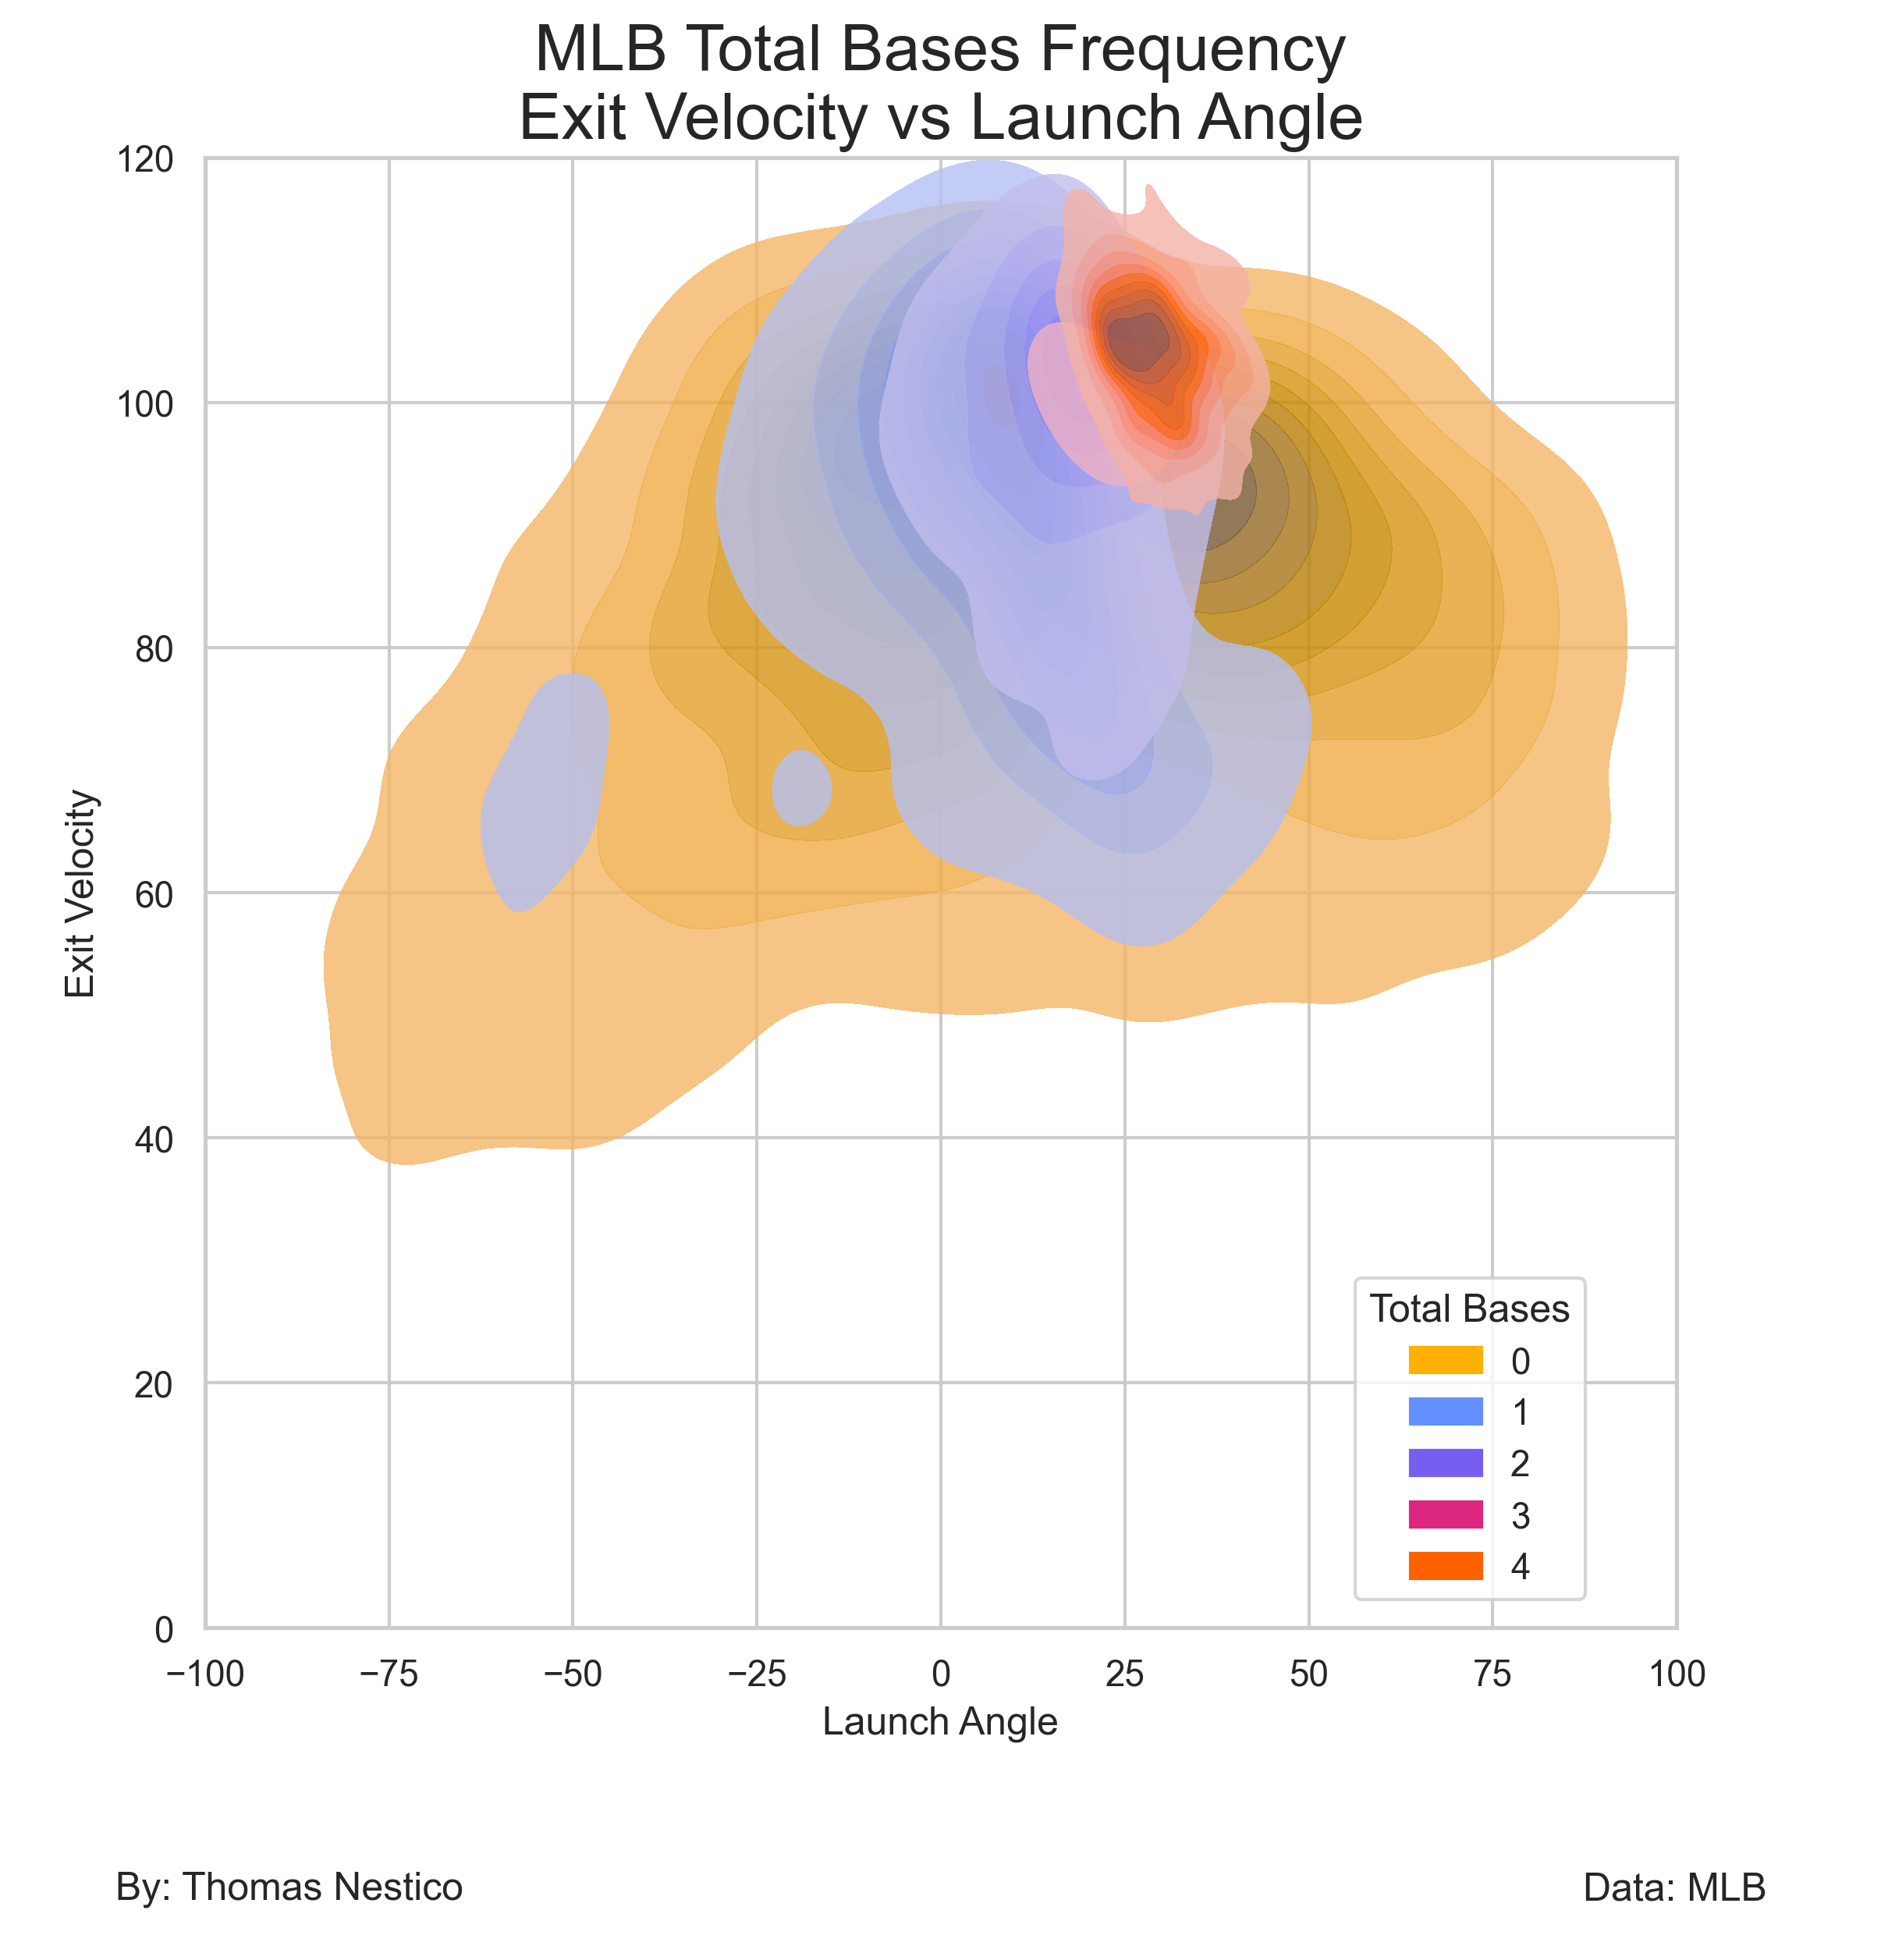

In [7]:
## Initialize plot

sns.set_theme(style="whitegrid", palette=None)
fig = plt.figure(figsize=(8,8),dpi=300)

## Create a grid of subplots to maintain layout
gs = GridSpec(2, 3, height_ratios=[10,1], width_ratios=[0.5,10,0.5])

## Add main subplot and footer subplot
ax = fig.add_subplot(gs[0, 1])
axfooter1 = fig.add_subplot(gs[-1, :])

## Define a custom palette for Total Base outcomes in KDE plot
custom_palette = {0: colour_palette[0], 1: colour_palette[1], 2: colour_palette[2], 3: colour_palette[3], 4: colour_palette[4]}

## Generate KDE plot. Sample 10000 events to avoid extended plotting period
sns.kdeplot(data=df_bip_train.sample(10000),
             x='launch_angle',
             y='launch_speed',
             hue='tb',ax=ax,
             palette=custom_palette,fill=True,alpha=0.8,legend='Total Bases') 

## Adjust legend and legend title
ax.get_legend().set_title('Total Bases')
ax.get_legend().set_bbox_to_anchor([0.75,0.1,0.2,0.15])

## Add title to plot
ax.set_title('MLB Total Bases Frequency\nExit Velocity vs Launch Angle',fontsize=20)

## Add axis labels to plot 
ax.set_xlabel('Launch Angle')
ax.set_ylabel('Exit Velocity')

## Adjust x and y-axis bounds
ax.set_ylim(0,120)
ax.set_xlim(-100,100)

## Add footer text 
axfooter1.text(.05, 0.2, "By: Thomas Nestico",ha='left', va='bottom',fontsize=12)
axfooter1.text(0.95, 0.2, "Data: MLB",ha='right', va='bottom',fontsize=12)
axfooter1.axis('off')


# Adjusting subplot to center it within the figure
fig.subplots_adjust(left=0.01, right=0.99, top=0.975, bottom=0.025)

The machine learning model which we will train will be able to provide probabilities of outcomes, rather than a singular outcome. We can multiply these probabilities by the wOBA coefficients to calculate our own xwOBACON (xwOBA on Contact) metric.

#### Feature Selection
Select features and target that will be utilized in the training of the model

In [8]:
## Features for the model will be launch angle, launch speed
features = ['launch_angle','launch_speed']

## Target will be Total Bases

target = 'tb'

## Clean up training data
df_model_bip_train = df_bip_train.dropna(subset=features+[target])

#### Model Training

We will be using KNN to train a model to predict batted ball outcomes. This model will provide us probabilities which we can use to calculate an expected wOBA metric.

In [9]:
## Import Machine learning packages and functions
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, r2_score

## Define feature data and target data as X and y
X = df_model_bip_train[features]
y = df_model_bip_train[target]

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create a KNN classifier
k_value = 11 
model = KNeighborsClassifier(n_neighbors=k_value)

## Train the model on the training data
model.fit(X_train, y_train)

## Make predictions on the testing data
y_pred = model.predict(X_test)

## Evaluate the performance of the model
classification_rep = classification_report(y_test, y_pred, zero_division=1)

## Print the results
print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.85     39112
           1       0.61      0.50      0.55     11933
           2       0.39      0.14      0.21      3760
           3       1.00      0.00      0.00       321
           4       0.71      0.67      0.69      2620

    accuracy                           0.76     57746
   macro avg       0.70      0.44      0.46     57746
weighted avg       0.74      0.76      0.74     57746



#### Performance
The accuracy of our model is 76%. This means that from the test set, our model correctly predicted the total bases of 76% of the data points given their launch speed and launch angle. While this might not seem encouraging, it should be noted that we are not fully interested in a single classification, rather the probabilities. As we visualized previously, there is a lot of overlap in outcomes with the selected features. In my opinion, an accuracy of 76% shows that we are on the right track because it is unlikely that a machine learning model can predict total bases at a high degree of accuracy when limited to our two features.


#### Confusion Matrix

An interesting observation that I noticed was that the model predicted 0 triples in the test set. This outcome may seem odd, but given the rarity of triples, and the likelihood that when they are hit, they have similar batted ball metrics to other events. The model predicted a lot more outs than reality, which makes sense because the model does not consider factors such as spray angle and defence into the equation.

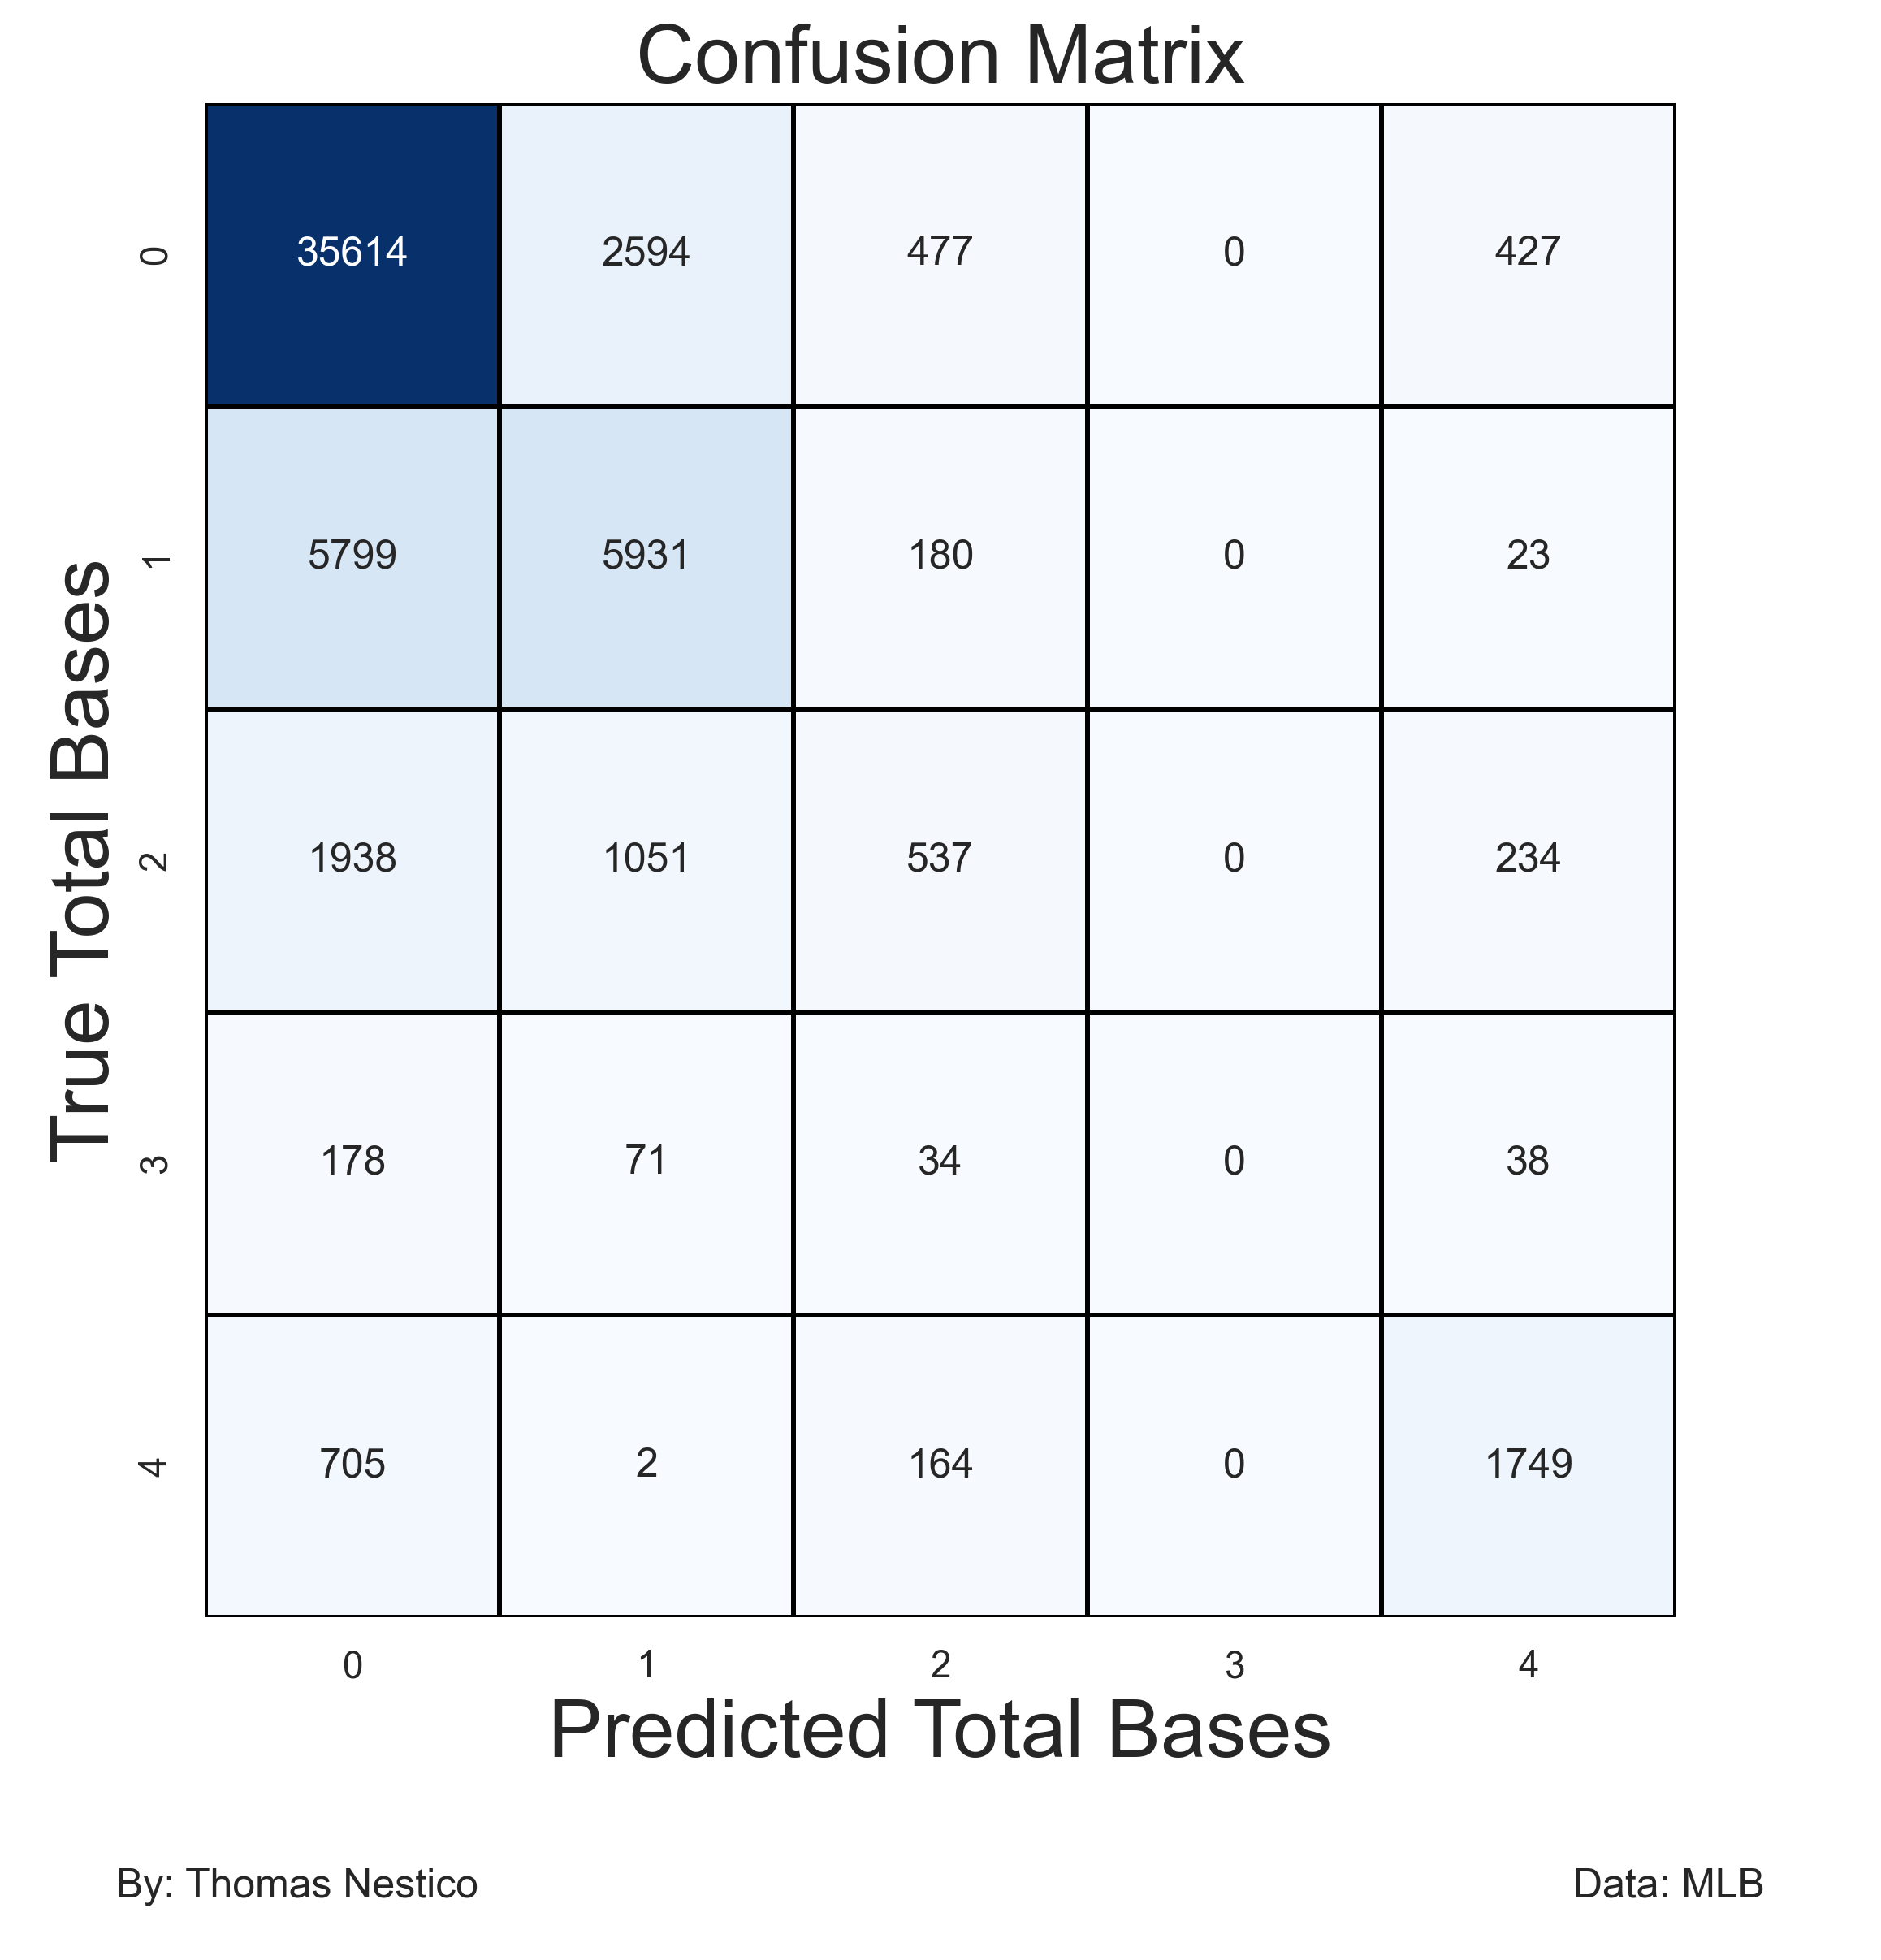

In [10]:
## Initialize Plot
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,8),dpi=300)

## Create a grid of subplots to maintain layout
gs = GridSpec(2, 3, height_ratios=[10,1], width_ratios=[0.5,10,0.5])

## Add main subplot and footer subplot
ax = fig.add_subplot(gs[0, 1])  # Subplot at the top-right position
axfooter1 = fig.add_subplot(gs[-1, :])

## Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

## Display the confusion matrix as a heatmap
sns.heatmap(cm,
            annot=True,
            fmt="d",
            linewidths=1,
            linecolor='black',
            cmap="Blues",
            cbar=False,
            ax=ax)

## Add plot tilte and axis labels
ax.set_xlabel("Predicted Total Bases",fontsize=24)
ax.set_ylabel("True Total Bases",fontsize=24)
ax.set_title("Confusion Matrix",fontsize=24)

## Add footer text 
axfooter1.text(.05, 0.2, "By: Thomas Nestico",ha='left', va='bottom',fontsize=12)
axfooter1.text(0.95, 0.2, "Data: MLB",ha='right', va='bottom',fontsize=12)
axfooter1.axis('off')


## Adjusting subplot to center it within the figure
fig.subplots_adjust(left=0.03, right=0.97, top=0.97, bottom=0.03)

### Calculating wOBA

From Fangrpahs, [wOBA for the 2023 season is defined as](https://library.fangraphs.com/offense/woba/): 
$$
\text{wOBA} = \frac{0.696\cdot uBB + 0.726\cdot HBP + 0.833\cdot 1B + 1.244\cdot 2B + 1.569\cdot 3B + 2.004\cdot HR}{AB + BB - IBB + SF + HBP}
$$

Where:
- uBB = Unintentional Base on Balls (Walks)
- HBP = Hit by Pitch
- 1B = Singles
- 2B = Doubles
- 3B = Triples
- HR = Home Run
- AB = At Bat
- BB = Base on Balls (Walks)
- IBB = Intentional Base on Balls (Walks)
- SF = Sacrifice Flies

Our model provides the probabilities of each batted ball outcome. With this, we can calculate an Expected wOBA value by calculating the expected value of wOBA for each event. This Expected wOBA value is known as xwOBA.

### Calculating xwOBA

Our model provides batted ball outcomes, also known as contact outcomes. Due to this, we can calculate the expected wOBA on Contact (xwOBACON) for each batted ball event. Following that, we can consider other events such as walks, hit by pitch, and strikeouts to calcaulte xwOBA.

The formula to calculate xwOBACON for a single event is the expected value of wOBACON returned by the model:

$$
\text{xwOBACON}_{\text{i}} = E(\text{xwOBACON}_{\text{i}})= \sum_{x=0}^{4} P(x) \cdot \text{xwOBA}_{\text{x}}
$$

Where:
- xwOBACON<sub>i</sub> is Expected wOBACON for a batted ball event, it is also the Expected Value of wOBACON, E(wOBACON<sub>i</sub>)
- x represents the total bases of an event (e.g 1 represents a single)
- P(x) represents the probability of total bases from an event
- wOBA<sub>x</sub> represents the 2023 wOBA coefficient for the given outcome

We now have a way to calculate xwOBACON with a machine learning model utilizing the KNN algorithm. To calculate xwOBA we will need to consider events that are not batted ball events that also impact wOBA. These events include:
- Unintentional Base on Balls (walk)
- Hit By Pitch
- Strikeouts

To calculate xwOBA for a single batter, we utilize the wOBA formula from before and substitute their summation of xwOBACON into the equation. The yields:

$$
\text{xwOBA} = \frac{0.696\cdot uBB + 0.726\cdot HBP + \sum_{i=1}^{n}\text{xwOBACON}_{\text{i}}}{AB + BB - IBB + SF + HBP}
$$

With these formulas defined, we can proceed with calculating xwOBA for all (qualified) batters during the 2023 season

In [22]:
## Calculate wOBA for batted ball events (xwOBACON)
## Predcited values are [0,1,2,3,4], which represent Total Bases.
## This list comprehension create a column in our 2023 batted ball dataset with the xwOBACON predictions
df_bip_2023['woba_pred'] = [sum(x) for x in model.predict_proba(df_bip_2023[features]) * ([0, 0.883,1.244,1.569,2.004])]
print(df_bip_2023)
df_2023_output = df_bip_2023.groupby(['batter_id','batter_name']).agg(
    woba_pa = ('woba_pred','count'),
    wobacon = ('woba','mean'),
    xwobacon = ('woba_pred','mean'))

df_2023_output = df_2023_output[df_2023_output['woba_pa'] > 100]
    
## Display the top 20
df_2023_output[df_2023_output['woba_pa'] > 100].sort_values(by='xwobacon',ascending=False).head(20)

        game_id   game_date  batter_id                   batter_name  \
3        718780  2023-03-30     660670              Ronald Acuña Jr.   
20       718780  2023-03-30     645277                  Ozzie Albies   
25       718780  2023-03-30     657041                   Lane Thomas   
28       718780  2023-03-30     608841                  Joey Meneses   
32       718780  2023-03-30     600869             Jeimer Candelario   
...         ...         ...        ...                           ...   
720655   716353  2023-10-01     663886              Tyler Stephenson   
720670   716353  2023-10-01     676761                  Irving Lopez   
720675   716353  2023-10-01     687952  Christian Encarnacion-Strand   
720676   716353  2023-10-01     682622                  Noelvi Marte   
720677   716353  2023-10-01     666181                   Will Benson   

       batter_hand batter_team  batter_team_id  pitcher_id    pitcher_name  \
3                R         ATL             144      57157

/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_80869/3585989539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bip_2023['woba_pred'] = [sum(x) for x in model.predict_proba(df_bip_2023[features]) * ([0, 0.883,1.244,1.569,2.004])]


,,woba_pa,wobacon,xwobacon
batter_id,batter_name,,,
592450,Aaron Judge,239,0.556084,0.650927
660271,Shohei Ohtani,356,0.554862,0.542527
676369,Nelson Velázquez,112,0.489080,0.519318
502110,J.D. Martinez,293,0.516802,0.516578
545361,Mike Trout,206,0.473015,0.511159
670242,Matt Wallner,133,0.504887,0.506718
670541,Yordan Alvarez,321,0.467480,0.502803
641343,Jake Bauers,150,0.414227,0.496202
542303,Marcell Ozuna,396,0.464722,0.495460


In [12]:
## Since did not alter the indices, we can assign the predicted xwOBACON to the 2023 dataset 
df_2023['woba_pred'] = df_bip_2023['woba_pred']

## Assign a value of 0.696 to every walk in the dataset
df_2023.loc[df_2023['event_type'].isin(['walk']),'woba_pred'] = 0.696

## Assign a value of 0.726 to every hit by pitch in the dataset
df_2023.loc[df_2023['event_type'].isin(['hit_by_pitch']),'woba_pred'] = 0.726

## Assign a value of 0 to every Strikeout in the dataset 
df_2023.loc[df_2023['event_type'].isin(['strikeout','strikeout_double_play']),'woba_pred'] = 0

## Create a dataframe which is just wOBA events
df_2023_woba = df_2023.dropna(subset=['woba_pred'])

/var/folders/pn/s56mk9md5zzd_jwqqhtnf7fr0000gn/T/ipykernel_80869/4282413510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['woba_pred'] = df_bip_2023['woba_pred']


In [13]:
## Groupby Batter ID and Name to calculate wOBA and xwOBA for all players during 2023 MLB Season
df_2023_output = df_2023_woba.groupby(['batter_id','batter_name']).agg(
    woba_pa = ('woba_pred','count'),
    woba = ('woba','mean'),
    xwoba = ('woba_pred','mean'))

## Only include batters with at least 100 wOBA PA
df_2023_output = df_2023_output[df_2023_output['woba_pa'] > 100]
    
## Display the top 20
df_2023_output[df_2023_output['woba_pa'] > 100].sort_values(by='xwoba',ascending=False).head(20)

,,woba_pa,woba,xwoba
batter_id,batter_name,,,
592450,Aaron Judge,448,0.419393,0.469990
660670,Ronald Acuña Jr.,729,0.427038,0.449225
670541,Yordan Alvarez,490,0.416414,0.439555
660271,Shohei Ohtani,572,0.434316,0.426639
608369,Corey Seager,527,0.418685,0.416078
518692,Freddie Freeman,715,0.412404,0.407737
605141,Mookie Betts,690,0.416577,0.407374
665742,Juan Soto,695,0.395524,0.406270
542303,Marcell Ozuna,589,0.382316,0.402982


In [15]:
## Import MLB xwOBA Data
df_savant = pd.read_csv('expected_stats.csv')

## merge our model xwOBA with MLB xwOBA. Only include qualified batters
df_2023_output_merge = df_2023_output.reset_index().merge(right=df_savant,
                                                          left_on='batter_id',
                                                          right_on='player_id',
                                                          suffixes = ['','_MLB']).set_index(['batter_id','batter_name'])

In [17]:
## Copy data to clipboard for easy pasting into a spreadsheet
df_2023_output_merge[['woba_pa','woba','xwoba','est_woba']].sort_values('est_woba',ascending=False).to_clipboard()

We can use a scatter plot to visualize xwOBA (TJStats) with xwOBA (MLB)

Text(0.21, 0.475, '$R^{2}$ = 0.96')

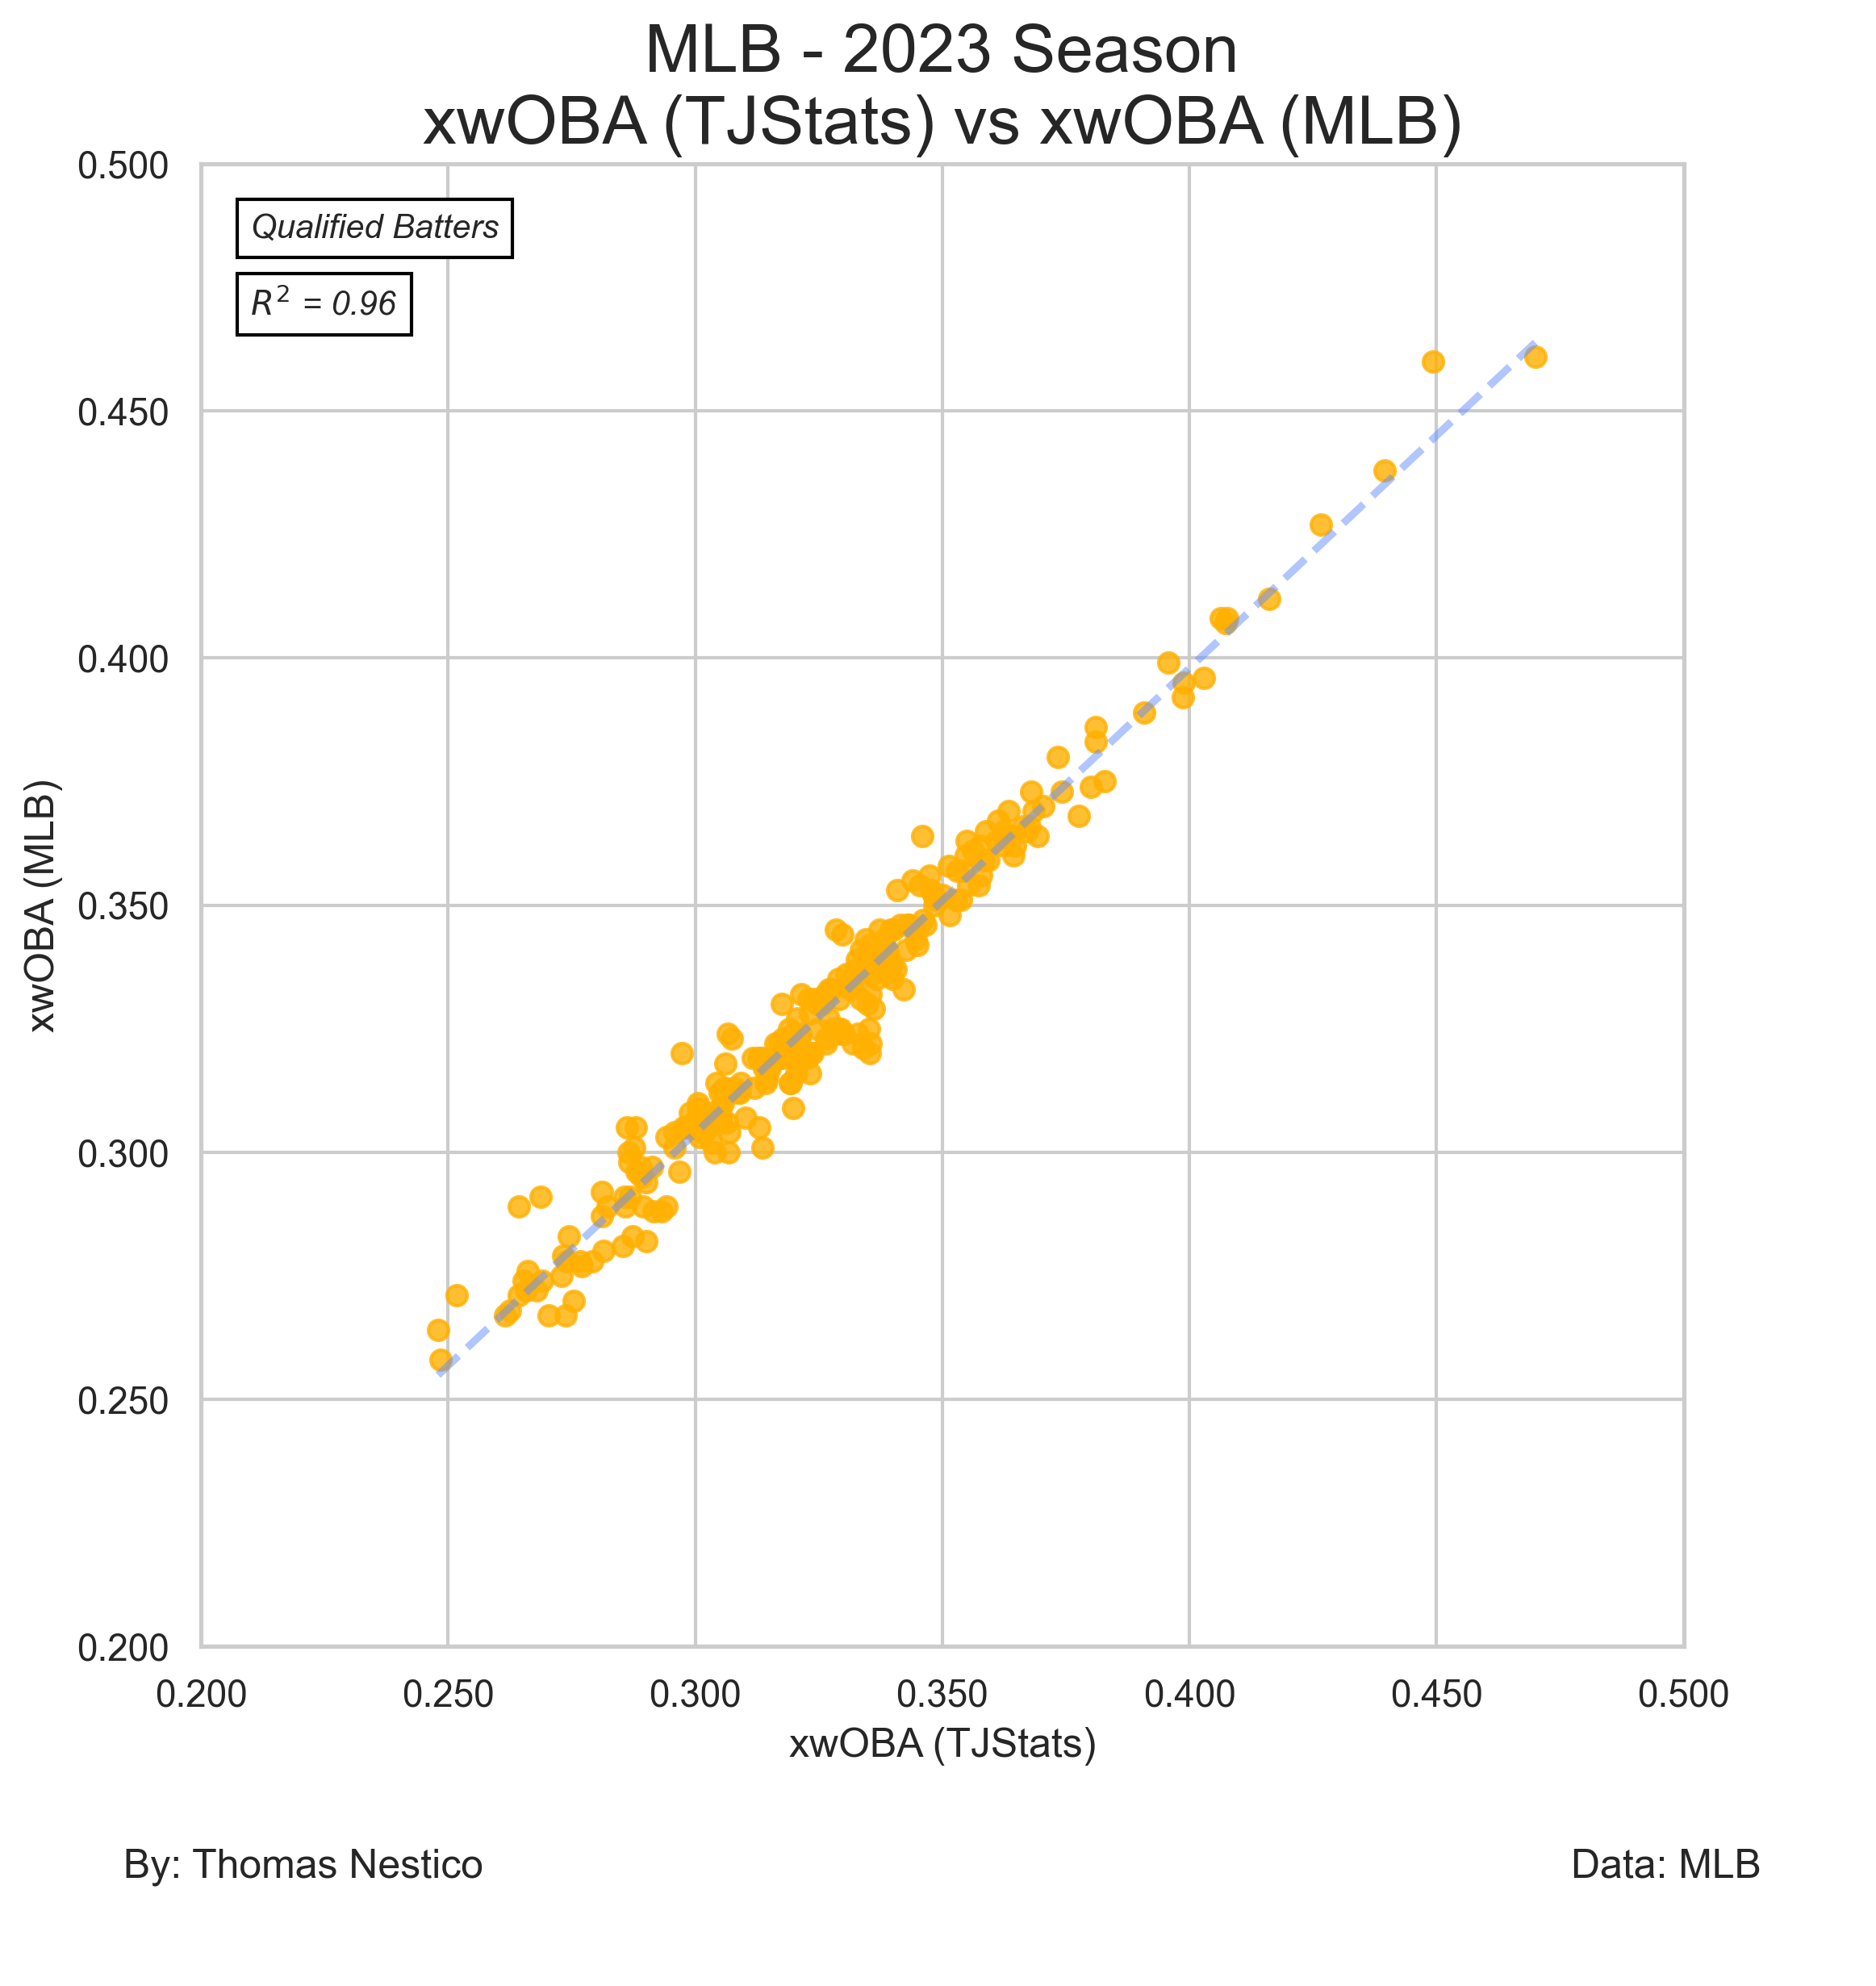

In [18]:
## Initialize Plot
sns.set_theme(style="whitegrid", palette="pastel")
fig = plt.figure(figsize=(8,8),dpi=300)

## Create a grid of subplots to maintain layout
gs = GridSpec(2, 3, height_ratios=[12,1], width_ratios=[0.5,12,0.5])

## Add main subplot and footer subplot
ax = fig.add_subplot(gs[0, 1])
axfooter1 = fig.add_subplot(gs[-1, :])

## Plot Regression plot
sns.regplot(data=df_2023_output_merge,
             x='xwoba',
             y='est_woba',
             #color=colour_palette[0],
            scatter_kws={"color": colour_palette[0]},  # Set color of scatter points
            line_kws={"color": colour_palette[1],"linestyle":'dashed',"alpha":0.5},ci=None,ax=ax) 

## Make axis square
ax.axis('square')

## Define x and y bounds
ax.set_xlim(0.2,0.5)
ax.set_ylim(0.2,0.5)

## Import function to format x and y ticks 
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

## Add Title
ax.set_title('MLB - 2023 Season\nxwOBA (TJStats) vs xwOBA (MLB)',fontsize=20)

## Set Labels
ax.set_xlabel('xwOBA (TJStats)')
ax.set_ylabel('xwOBA (MLB)')

## Add fotter text
axfooter1.text(.05, 0.6, "By: Thomas Nestico",ha='left', va='bottom',fontsize=12)
axfooter1.text(0.95, 0.6, "Data: MLB",ha='right', va='bottom',fontsize=12)
axfooter1.axis('off')

## Adjusting subplot to center it within the figure
fig.subplots_adjust(left=0.03, right=0.97, top=0.97, bottom=0.03)

## Add text with information regarding data points shown and correlation
ax.text(x=0.21,
        y=0.49,
        s=f'Qualified Batters',
        fontsize='10',
        fontstyle='oblique',
        va='top',
        bbox=dict(facecolor='white', edgecolor='black'))

ax.text(x=0.21,
        y=0.475,
        s=r"$R^{2}$" + f" = {r2_score(df_2023_output_merge['xwoba'],df_2023_output_merge['est_woba']):.2f}",
        fontsize='10',
        fontstyle='oblique',
        va='top',
        bbox=dict(facecolor='white', edgecolor='black'))

With a R<sup>2</sup> of 0.98, xwOBA (TJStats) matches up exceptionally well with xwOBA (MLB). 

Here is a link to a spreadsheet with the predicted xwOBA generated by the model: https://docs.google.com/spreadsheets/d/19CQ9aripVAYd1TrBkf_BWJ5ZpnTPM3j2-kelh292Fvg/edit?usp=sharing

This spreadsheet includes all qualified batters during the 2023 MLB season and lists their wOBA, xwOBA (TJStats), xwOBA (MLB), and xwOBA differences.


#### Limitations
In machine learning, there will almost always be limitations when training a model. In our case, our biggest limitations were with respect to data and accessibility. xwOBA (MLB) utilizes sprint speed during certain batted ball events to better capture a batter’s offensive ability. In xwOBA (TJStats) we were limited to just 2 features, Launch Speed and Launch Angle, as other features have not been made available by MLB. Despite this limitation, we trained a model to predict xwOBA which matched up very well with the xwOBA (MLB).

Looking at the difference column from the output spreadsheet, the batters with the largest deviation between xwOBA are those that rank on the extreme ends of the sprint speed leaderboards. For example, Jon Berti and Alek Thomas are undervalued in our model, and they rank in the 95th and 97th percentile for sprint speed respectively. On the opposite end, our model overvalues Dominic Smith and Pete Alonso, who rank in the 14th and 18th percentile in sprint speed respectively.

The use of KNN was most likely limiting, as it only considers Euclidean distance between data points and cannot capture any interaction between features. An algorithm such as Random Forest may have proven to be more robust and accurate.

### Conclusion
The purpose of this article was to provide readers a deeper dive into a very valuable baseball metric, wOBA. This deep dive included defining the metric, explaining its “expected” variant, and training a machine learning model to recreate MLB’s outstanding work on this topic.

The choice of KNN was very deliberate. In my experience, KNN is one of the most interpretable machine learning algorithms, as it is intuitive and can be clearly illustrated with graphics.

To all readers, especially those who are new to baseball analytics and/or machine learning, I hope this article provided you with knowledge and enjoyment. Thank you for taking the time to read, and I hope you are now a wOBA truther (if you weren’t one already)!
